In [1]:
#this allows relative imports in notebook
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


from UCLSE.rl_trader import RLTrader
from UCLSE.rl_env import RLEnv
from UCLSE.custom_timer import CustomTimer
from UCLSE.message_environment import yamlLoad
from UCLSE.messenger import Messenger
from UCLSE.plotting_utilities import display_func
import os
import numpy as np
import pandas as pd

In this notebook we will see how an Reinforcement Learning experiment can easily be setup in BUCLSE.

Firstly we define a dictionary sufficient to define a trading environment as before.

In [2]:
environ_dic={
'start_time': 0.0,
 'end_time': 600.0, #how long the experiment goes on for
 'supply_price_low': 95,
 'supply_price_high': 95,
 'demand_price_low': 105,
 'demand_price_high': 105,
 'interval': 30,
 'timemode': 'drip-poisson',
 'buyers_spec': {'GVWY': 10, 'SHVR': 10, 'ZIC': 10, 'ZIP': 10}, #how many of each type of trader we want
 'sellers_spec': {'GVWY': 10, 'SHVR': 10, 'ZIC': 10, 'ZIP': 10},
 'verbose': False,
 'trade_file': 'avg_balance.csv', #profit and loss summary by trader type
 'trade_record': 'transactions.csv', #list of all transactions
 'dump_each_trade': True} #record each trade


def geometric_q():
    return np.random.geometric(0.6)

environ_dic['quantity_f']=geometric_q

timer=CustomTimer(start=0,end=600,step=1/80)
messenger=Messenger()

environ_dic['timer']=timer
environ_dic['messenger']=messenger

environ_dic

{'start_time': 0.0,
 'end_time': 600.0,
 'supply_price_low': 95,
 'supply_price_high': 95,
 'demand_price_low': 105,
 'demand_price_high': 105,
 'interval': 30,
 'timemode': 'drip-poisson',
 'buyers_spec': {'GVWY': 10, 'SHVR': 10, 'ZIC': 10, 'ZIP': 10},
 'sellers_spec': {'GVWY': 10, 'SHVR': 10, 'ZIC': 10, 'ZIP': 10},
 'verbose': False,
 'trade_file': 'avg_balance.csv',
 'trade_record': 'transactions.csv',
 'dump_each_trade': True,
 'quantity_f': <function __main__.geometric_q()>,
 'timer': time: 0 time left: 48000.0 start: 0 end: 600 step: 0.0125,
 'messenger': <UCLSE.messenger.Messenger at 0x16e11fbc4e0>}

Next we define a RL trader. This has a parent type trader so shares all of the methods needed to intereact with BUCLSE. We will give it some initial inventory at a certain average cost.

In [3]:
rl_trader=RLTrader( ttype='RL', tid='RL', n_quote_limit=100
                   ,timer=timer,messenger=messenger)

adding exchange to RL trader  RL


Next we instantiate the RL environment. This is a subclass of the openai gym gym.EnV
This means it has render and step methods.

The RL environment will set up a Market_session object, (and through that associated exchange, traders and supply_demand objects).

The RL environment will actually iterate through a number of steps until the order book has depth = thresh on both sides

In [4]:
lobenv=RLEnv(RL_trader=rl_trader,environ_dic=environ_dic,thresh=4)


using timer start time=0, end time=600, instead
overwriting timer step size from: 0.01 to 0.0125
adding exchange to RL trader  RL


check what time it is, the eperiment will only begin once the LOB has reached a depth greater than the defined threshold. 

In [5]:
timer.time

4.625

The render method returns the lob

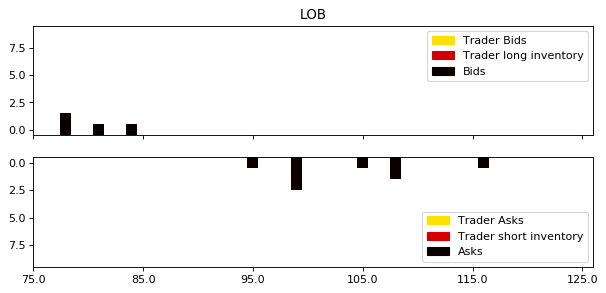

                          tid     
otype                     Ask  Bid
price time   qid oid qty          
69.0  4.6250 20  -38 1    NaN  B36
78.0  4.4125 18  -41 2    NaN  B39
81.0  3.8625 16  -20 1    NaN  B18
84.0  3.9375 17  -36 1    NaN  B34
95.0  3.6125 14  -57 1    S15  NaN
99.0  4.6125 19  -69 3    S27  NaN
105.0 3.0625 12  -81 1    S39  NaN
108.0 3.0125 11  -64 2    S22  NaN
116.0 2.8375 10  -73 1    S31  NaN


In [6]:
_=lobenv.render()

Give the RL trader inventory priced at mid point

In [8]:
rl_trader.setup_initial_inventory('Buy',1,lobenv.best_ask)
rl_trader.trade_manager

oid gen RL_13.325_1


inventory: 1, avg cost 96.0, direction Long, cash -96.0,

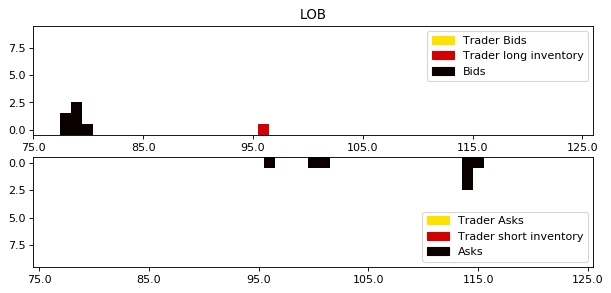

                           tid     
otype                      Ask  Bid
price time    qid oid qty          
78.0  12.3875 93  -40 2    NaN  B38
79.0  12.6625 96  -15 2    NaN  B13
      13.3250 102 -33 1    NaN  B31
80.0  13.0625 100 -21 1    NaN  B19
96.0  10.9750 83  -48 1    S06  NaN
100.0 12.4125 94  -66 1    S24  NaN
101.0 12.7500 97  -80 1    S38  NaN
114.0 9.0000  68  -70 2    S28  NaN
      12.8125 98  -69 1    S27  NaN
115.0 13.1500 101 -68 1    S26  NaN


In [10]:
_=lobenv.render()

The RL trader at this point can now submit actions, see results and receive rewards though the step method.

In [9]:
lobenv.action_dic

{(0, 0, 0): Do nothing,
 (1, 0, 0): cancel Bid,
 (1, 1, -1): Cross bid-ask spread and fill Bid quantity 1 at best,
 (1, 1, 0):  submit or replace Bid with spread 0 and quantity 1,
 (1, 1, 1):  submit or replace Bid with spread 1 and quantity 1,
 (1, 1, 2):  submit or replace Bid with spread 2 and quantity 1,
 (1, 1, 3):  submit or replace Bid with spread 3 and quantity 1,
 (1, 1, 4):  submit or replace Bid with spread 4 and quantity 1,
 (1, 1, 5):  submit or replace Bid with spread 5 and quantity 1,
 (-1, 0, 0): cancel Ask,
 (-1, -1, -1): Cross bid-ask spread and fill Ask quantity 1 at best,
 (-1, -1, 0):  submit or replace Ask with spread 0 and quantity 1,
 (-1, -1, 1):  submit or replace Ask with spread 1 and quantity 1,
 (-1, -1, 2):  submit or replace Ask with spread 2 and quantity 1,
 (-1, -1, 3):  submit or replace Ask with spread 3 and quantity 1,
 (-1, -1, 4):  submit or replace Ask with spread 4 and quantity 1,
 (-1, -1, 5):  submit or replace Ask with spread 5 and quantity 1}

Demonstrate how to submit an action with the standard step method. 

After the order is submitted to exchange, the timer is increased by one, and the traders in the environment have the opportunity to respond.

Rewards and stopping criteria are calculated.

The step function returns the state of the lob, reward and a boolean stopping variable.

LOB before


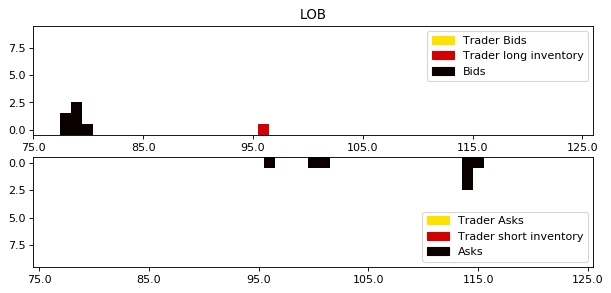

                           tid     
otype                      Ask  Bid
price time    qid oid qty          
78.0  12.3875 93  -40 2    NaN  B38
79.0  12.6625 96  -15 2    NaN  B13
      13.3250 102 -33 1    NaN  B31
80.0  13.0625 100 -21 1    NaN  B19
96.0  10.9750 83  -48 1    S06  NaN
100.0 12.4125 94  -66 1    S24  NaN
101.0 12.7500 97  -80 1    S38  NaN
114.0 9.0000  68  -70 2    S28  NaN
      12.8125 98  -69 1    S27  NaN
115.0 13.1500 101 -68 1    S26  NaN
{'bids': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'asks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False

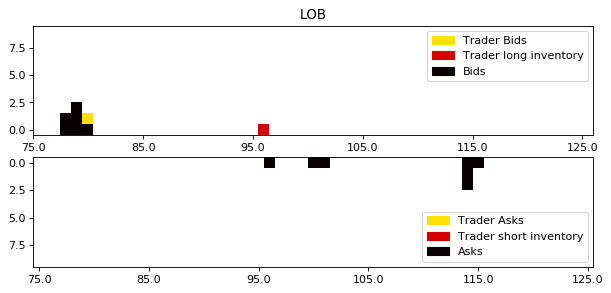

                                   tid     
otype                              Ask  Bid
price time    qid oid         qty          
78.0  12.3875 93  -40         2    NaN  B38
79.0  12.6625 96  -15         2    NaN  B13
      13.3250 102 -33         1    NaN  B31
80.0  13.0625 100 -21         1    NaN  B19
      13.3250 103 RL_13.325_2 1    NaN   RL
96.0  10.9750 83  -48         1    S06  NaN
100.0 12.4125 94  -66         1    S24  NaN
101.0 12.7500 97  -80         1    S38  NaN
114.0 9.0000  68  -70         2    S28  NaN
      12.8125 98  -69         1    S27  NaN
115.0 13.1500 101 -68         1    S26  NaN
{'bids': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'asks': array([[False, Fa

In [11]:
lobenv.sess.process_verbose=True #turn on the verbal messages from the exchange for exposition
print('LOB before')
_=lobenv.render())

print('RL trader does action (1,0,1) which is to add a bid order at 0 spread to best bid for quantity 1')
observation,reward,done,_=lobenv.step((1,1,0)) 
print('LOB after')
_=lobenv.render()
print(lobenv.trader.trade_manager)

observation is the state variable (here the public anonymous lob), reward is the reward received and done is a boolean informing whether the experiment has finished. 

To see what the reward and finishing functions are:

In [10]:
display_func('UCLSE.rl_env.RLEnv','stop_checker')

This will end when the inventory is greater than a limit, time has expired or the trader has no inventory and no open orders at exchange.

In [11]:
display_func('UCLSE.rl_env.RLEnv','reward_get')

Reward is positive if there is no inventory, no quotes and a positive cash balance, else reward is negative.

Check the last few changes happening at exchange

In [12]:
pd.DataFrame(lobenv.sess.exchange.tape).tail(5)

,oid,otype,p1_qid,p2_qid,party1,party2,price,qid,qty,tape_time,tid,time,type
112,-64,Ask,NaN,NaN,NaN,NaN,104.0,63.0,1,8.825,S22,8.8250,New Order
113,-33,Bid,NaN,NaN,NaN,NaN,82.0,58.0,1,8.875,B31,8.7375,Cancel
114,-33,Bid,NaN,NaN,NaN,NaN,82.0,64.0,1,8.875,B31,8.8750,New Order
115,-21,Bid,NaN,NaN,NaN,NaN,94.0,65.0,1,8.900,B19,8.9000,New Order
116,RL_8.9_2,Bid,NaN,NaN,NaN,NaN,94.0,66.0,1,8.900,RL,8.9000,New Order


Cancel the order with action (-1,0,0). RL trader not on LOB anymore

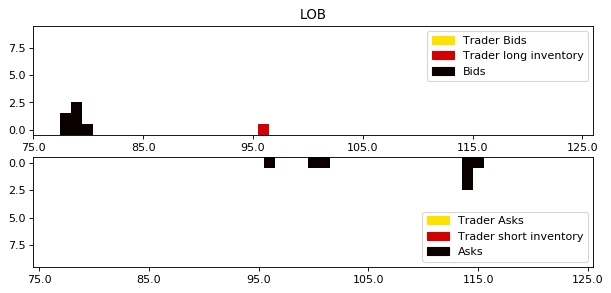

                           tid     
otype                      Ask  Bid
price time    qid oid qty          
78.0  12.3875 93  -40 2    NaN  B38
79.0  12.6625 96  -15 2    NaN  B13
      13.3250 102 -33 1    NaN  B31
80.0  13.0625 100 -21 1    NaN  B19
96.0  10.9750 83  -48 1    S06  NaN
100.0 12.4125 94  -66 1    S24  NaN
101.0 12.7500 97  -80 1    S38  NaN
114.0 9.0000  68  -70 2    S28  NaN
      12.8125 98  -69 1    S27  NaN
115.0 13.1500 101 -68 1    S26  NaN


In [13]:
_,reward,done,_=lobenv.step((1,0,0))
_=lobenv.render()

In [14]:
pd.DataFrame(lobenv.sess.exchange.tape).tail(5)

,oid,otype,p1_qid,p2_qid,party1,party2,price,qid,qty,tape_time,tid,time,type
113,-33,Bid,NaN,NaN,NaN,NaN,82.0,58.0,1,8.8750,B31,8.7375,Cancel
114,-33,Bid,NaN,NaN,NaN,NaN,82.0,64.0,1,8.8750,B31,8.8750,New Order
115,-21,Bid,NaN,NaN,NaN,NaN,94.0,65.0,1,8.9000,B19,8.9000,New Order
116,RL_8.9_2,Bid,NaN,NaN,NaN,NaN,94.0,66.0,1,8.9000,RL,8.9000,New Order
117,RL_8.9_2,Bid,NaN,NaN,NaN,NaN,94.0,66.0,1,8.9125,RL,8.9000,Cancel


Buy at best bid. Note that this will end the experiment since the inventory limit is 1.

oid gen RL_13.375_4
add_order < response=Proceed (time,oid,qid) None
<RLEnv instance>
inventory: 3, avg cost 97.3333, direction Long, cash -292.0,
reward:-1,finished: True


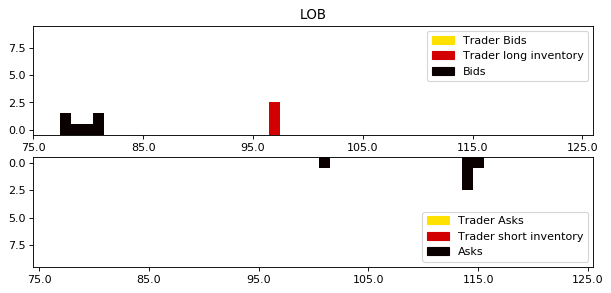

                           tid     
otype                      Ask  Bid
price time    qid oid qty          
78    12.3875 93  -40 2    NaN  B38
79    13.3250 102 -33 1    NaN  B31
80    13.0625 100 -21 1    NaN  B19
81    13.3750 105 -15 2    NaN  B13
101   12.7500 97  -80 1    S38  NaN
114   9.0000  68  -70 2    S28  NaN
      12.8125 98  -69 1    S27  NaN
115   13.1500 101 -68 1    S26  NaN


In [15]:
_,reward,done,_=lobenv.step((1,1,-1))

print(lobenv)
print(lobenv.trader.trade_manager)
print(f'reward:{reward},finished: {done}')
_=lobenv.render()

In [26]:
pd.DataFrame(lobenv.sess.exchange.tape).tail(5)

,oid,otype,p1_qid,p2_qid,party1,party2,price,qid,qty,tape_time,tid,time,type
126,None,Ask,NaN,NaN,NaN,NaN,95.0,45.0,1,8.9625,S10,7.5750,Fill
127,None,Bid,NaN,NaN,NaN,NaN,95.0,70.0,1,8.9625,RL,8.9625,Fill
128,NaN,NaN,45.0,70.0,S10,RL,95.0,NaN,1,8.9625,NaN,NaN,Trade
129,-64,Ask,NaN,NaN,NaN,NaN,104.0,63.0,1,8.9750,S22,8.8250,Cancel
130,-64,Ask,NaN,NaN,NaN,NaN,104.0,71.0,1,8.9750,S22,8.9750,New Order


The reset command returns the trader back to starting inventory. The order book is maintained. 

In [16]:
rl_trader.reset()
rl_trader.setup_initial_inventory('Buy',1,lobenv.mid_price)
rl_trader.trade_manager

oid gen RL_13.3875_5


inventory: 1, avg cost 91.0, direction Long, cash -91,

LOB before


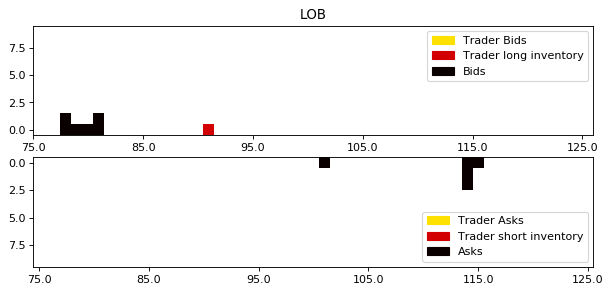

                           tid     
otype                      Ask  Bid
price time    qid oid qty          
78    12.3875 93  -40 2    NaN  B38
79    13.3250 102 -33 1    NaN  B31
80    13.0625 100 -21 1    NaN  B19
81    13.3750 105 -15 2    NaN  B13
101   12.7500 97  -80 1    S38  NaN
114   9.0000  68  -70 2    S28  NaN
      12.8125 98  -69 1    S27  NaN
115   13.1500 101 -68 1    S26  NaN
oid gen RL_13.3875_6
add_order < response=Proceed (time,oid,qid) None
LOB after


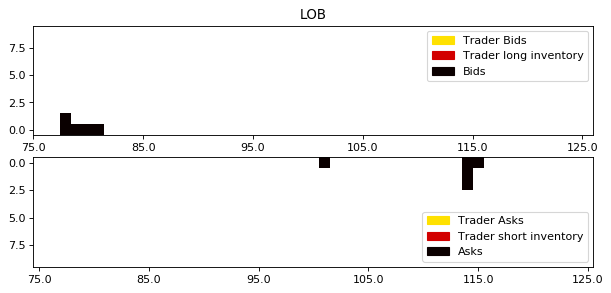

                                  tid     
otype                             Ask  Bid
price time    qid        oid qty          
78    12.3875 93.000000  -40 2    NaN  B38
79    13.3250 102.000000 -33 1    NaN  B31
80    13.0625 100.000000 -21 1    NaN  B19
81    13.3750 105.000001 -15 1    NaN  B13
101   12.7500 97.000000  -80 1    S38  NaN
114   9.0000  68.000000  -70 2    S28  NaN
      12.8125 98.000000  -69 1    S27  NaN
115   13.1500 101.000000 -68 1    S26  NaN
inventory: 0, avg cost 0, direction Long, cash -10,


In [18]:

print('LOB before')
_=lobenv.render()


observation,reward,done,_=lobenv.step((-1,-1,-1)) 
print('LOB after')
_=lobenv.render()
print(lobenv.trader.trade_manager)

In [19]:
rl_trader.blotter

{'RL_13.3625_3': [{'tid': 'RL',
   'otype': 'Bid',
   'client_price': 96.0,
   'order_qty': 1,
   'order_issue_time': 13.3625,
   'accession_time': 13.3625,
   'qid': 104.0,
   'oid': 'RL_13.3625_3',
   'exec_time': 13.3625,
   'exec_qty': 1,
   'exec_price': 96.0,
   'profit': 0,
   'improvement': 0.0,
   'BS': 'Buy',
   'status': 'complete'}],
 'RL_13.375_4': [{'tid': 'RL',
   'otype': 'Bid',
   'client_price': 100,
   'order_qty': 1,
   'order_issue_time': 13.375,
   'accession_time': 13.375,
   'qid': 106.0,
   'oid': 'RL_13.375_4',
   'exec_time': 13.375,
   'exec_qty': 1,
   'exec_price': 100,
   'profit': 0,
   'improvement': 0,
   'BS': 'Buy',
   'status': 'complete'}],
 'RL_13.3875_6': [{'tid': 'RL',
   'otype': 'Ask',
   'client_price': 81,
   'order_qty': 1,
   'order_issue_time': 13.3875,
   'accession_time': 13.3875,
   'qid': 107.0,
   'oid': 'RL_13.3875_6',
   'exec_time': 13.3875,
   'exec_qty': 1,
   'exec_price': 81,
   'profit': -10,
   'improvement': 0,
   'BS': 'Se